# 00 라이브러리 로딩 #

In [90]:
import pandas as pd
import numpy as np
import pickle

from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [4]:
# Load variables #
with open('train_test_df.pickle', 'rb') as pic:
    train_df, test_df = pickle.load(pic)

# 01 기술통계량 #

## 민원 건당 단어 수 ##
### Word2vec 모델 파라메터 값 설정에 참고될 통계량 ###

### 학습 데이터 ###

In [8]:
train_df['tokens_stop'].str.len().describe()

count    9867.000000
mean      110.636870
std       110.371245
min         0.000000
25%        51.500000
50%        83.000000
75%       136.000000
max      3640.000000
Name: tokens_stop, dtype: float64

### 테스트 데이터 ###

In [10]:
test_df['tokens_stop'].str.len().describe()

count    4160.000000
mean       96.090385
std       142.525102
min         0.000000
25%        26.000000
50%        62.000000
75%       120.000000
max      4024.000000
Name: tokens_stop, dtype: float64

# 02 Word2vec 모델링 #
### 코드 참고 : https://programmers.co.kr/learn/courses/21 ###

## Word2vec 파라미터 값 지정 ##

In [91]:
train_documents = train_df['tokens_stop'].to_list() # 학습데이터 토크나이징 완료한 문서
test_documents = test_df['tokens_stop'].to_list() # 학습데이터 토크나이징 완료한 문서

In [71]:
num_features = 5000 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 12 # 병렬 처리 스레드 수
context = 20 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

## 모델 학습 ##

In [72]:
model = word2vec.Word2Vec(train_documents,
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)

2019-12-18 16:42:46,634 : INFO : collecting all words and their counts
2019-12-18 16:42:46,635 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-18 16:42:46,797 : INFO : collected 22197 word types from a corpus of 1091654 raw words and 9867 sentences
2019-12-18 16:42:46,798 : INFO : Loading a fresh vocabulary
2019-12-18 16:42:46,809 : INFO : effective_min_count=40 retains 3904 unique words (17% of original 22197, drops 18293)
2019-12-18 16:42:46,810 : INFO : effective_min_count=40 leaves 958671 word corpus (87% of original 1091654, drops 132983)
2019-12-18 16:42:46,822 : INFO : deleting the raw counts dictionary of 22197 items
2019-12-18 16:42:46,823 : INFO : sample=0.001 downsamples 31 most-common words
2019-12-18 16:42:46,823 : INFO : downsampling leaves estimated 921174 word corpus (96.1% of prior 958671)
2019-12-18 16:42:46,833 : INFO : estimated required memory for 3904 words and 5000 dimensions: 158112000 bytes
2019-12-18 16:42:46,834 : INFO : res

In [73]:
# 모델 확인
model

### 특정 단어와 가장 유사한 단어 추출 ###

In [79]:
model.wv.most_similar('자전거')

[('따릉이', 0.7490906715393066),
 ('도난', 0.7327911853790283),
 ('공공자전거', 0.7207876443862915),
 ('자전거도로', 0.6639872789382935),
 ('등록제', 0.6565660834312439),
 ('대여소', 0.6241257786750793),
 ('헬멧', 0.6213035583496094),
 ('보관소', 0.6116853952407837),
 ('대여', 0.595969557762146),
 ('안전모', 0.5726012587547302)]

In [81]:
model.wv.most_similar('미세먼지')

[('농도', 0.9058353900909424),
 ('미세', 0.876221239566803),
 ('공기', 0.8278692960739136),
 ('오염', 0.8141537308692932),
 ('물질', 0.7832568883895874),
 ('황사', 0.781394362449646),
 ('청정기', 0.7672120332717896),
 ('배기가스', 0.7647069692611694),
 ('온난', 0.7573239803314209),
 ('저감', 0.7538762092590332)]

### 입력한 복수의 단어 中 유사하지 않은 단어 추출 ###

In [80]:
model.wv.doesnt_match('자전거 버스 택시'.split())

C:\Users\Administrator\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'자전거'

In [82]:
model.wv.doesnt_match('임산부 노인 시민'.split())

C:\Users\Administrator\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'시민'

### 확습 완료 후 필요없는 메모리 unload ###

In [74]:
model.init_sims(replace=True)

2019-12-18 16:44:06,411 : INFO : precomputing L2-norms of word weight vectors


### 모델 저장 ###

In [75]:
model_name = '5000features_40minwords_20context' #모델 이름 지정
model.save(f'./model/{model_name}')

2019-12-18 16:44:16,911 : INFO : saving Word2Vec object under ./model/5000features_40minwords_20context, separately None
2019-12-18 16:44:16,912 : INFO : storing np array 'vectors' to ./model/5000features_40minwords_20context.wv.vectors.npy
2019-12-18 16:44:17,308 : INFO : not storing attribute vectors_norm
2019-12-18 16:44:17,309 : INFO : storing np array 'syn1neg' to ./model/5000features_40minwords_20context.trainables.syn1neg.npy
2019-12-18 16:44:17,738 : INFO : not storing attribute cum_table
2019-12-18 16:44:17,844 : INFO : saved ./model/5000features_40minwords_20context


### t-SNE로 word2vec 모델 시각화 ###

In [76]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
model = g.Doc2Vec.load(f'./model/{model_name}')

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2) # 2개의 차원

2019-12-18 16:44:24,845 : INFO : loading Doc2Vec object from ./model/5000features_40minwords_20context
2019-12-18 16:44:24,868 : INFO : loading wv recursively from ./model/5000features_40minwords_20context.wv.* with mmap=None
2019-12-18 16:44:24,869 : INFO : loading vectors from ./model/5000features_40minwords_20context.wv.vectors.npy with mmap=None
2019-12-18 16:44:25,158 : INFO : setting ignored attribute vectors_norm to None
2019-12-18 16:44:25,158 : INFO : loading vocabulary recursively from ./model/5000features_40minwords_20context.vocabulary.* with mmap=None
2019-12-18 16:44:25,159 : INFO : loading trainables recursively from ./model/5000features_40minwords_20context.trainables.* with mmap=None
2019-12-18 16:44:25,159 : INFO : loading syn1neg from ./model/5000features_40minwords_20context.trainables.syn1neg.npy with mmap=None
2019-12-18 16:44:25,445 : INFO : setting ignored attribute cum_table to None
2019-12-18 16:44:25,446 : INFO : loaded ./model/5000features_40minwords_20conte

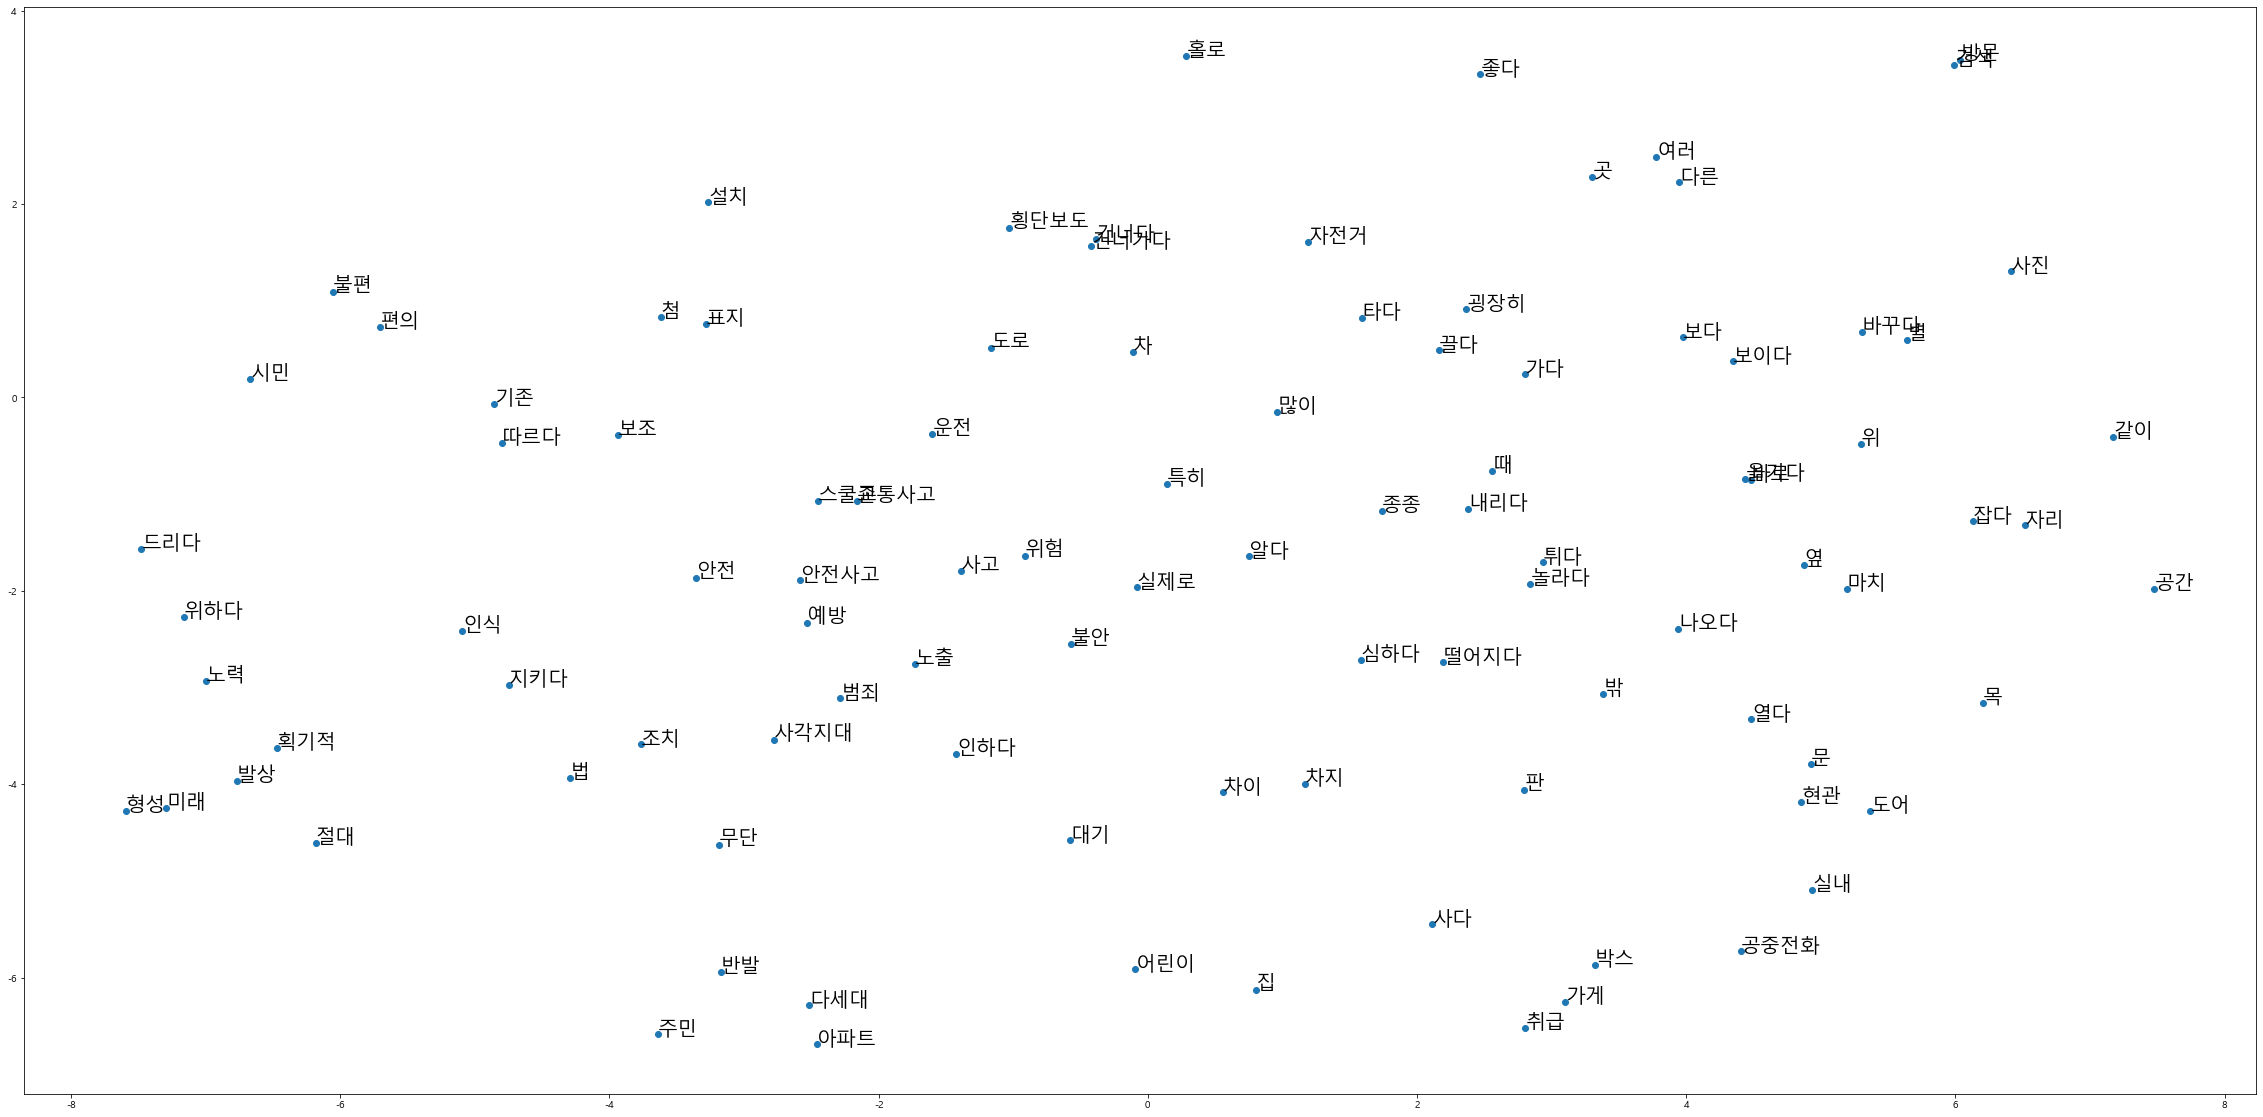

In [77]:
# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

w2v_df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_df.shape
w2v_df.head(10)

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_df['x'], w2v_df['y'])

for word, pos in w2v_df.iterrows():
    ax.annotate(word, pos, fontsize=20)
plt.show()

## 문서별 평균 feature 계산 ##

### 주어진 민원 문서에서 단어 벡터의 평균 구하는 함수 ###

In [38]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    np.seterr(divide='ignore')
    featureVec = np.divide(featureVec,nwords)
    return featureVec

### 단어 평균 feature 벡터를 배열로 반환 ###

In [83]:
def getAvgFeatureVecs(documents, model, num_features):
    counter = 0.
    documentFeatureVecs = np.zeros(
        (len(documents),num_features),dtype="float32")
    for document in documents:
       if counter%2000. == 0.:
           print("민원 %d of %d" % (counter, len(documents)))
       documentFeatureVecs[int(counter)] = makeFeatureVec(document, model, num_features)
       counter = counter + 1.
    return documentFeatureVecs

### 학습 데이터 평균 feature 계산 ###

In [84]:
%time trainDataVecs = getAvgFeatureVecs(\
    train_documents, model, num_features)


민원 0 of 9867
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
민원 2000 of 9867
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
민원 4000 of 9867
민원 6000 of 9867
민원 8000 of 9867
Wall time: 8.33 s


In [85]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(trainDataVecs)
trainDataVecs=imp.transform(trainDataVecs) ##nan, infinite 제거

## 랜덤 포레스트로 민원 자동분류 ##

### 랜덤 포레스트 분류기 설정 ###

In [86]:
forest_w2v = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=2019,class_weight='balanced')

### 랜덤포레스트 모델 = Y: 민원분류, X:민원 문서당 평균 단어 feature ###

In [87]:
%time forest_w2v = forest_w2v.fit(trainDataVecs, train_df["비전"])

Wall time: 9.2 s


### cross validation 활용해 정확도 평가 ###

In [88]:
# 10개로 분할해 평가
%time score = np.mean(cross_val_score(\
    forest_w2v, trainDataVecs, \
    train_df["비전"], cv=10))

Wall time: 1min 25s


In [89]:
# 정확도(accuracy)
score

0.6862222071513859

### 최종 모델을 활용해서 테스트 데이터 민원 자동 분류 ###

In [92]:
# 테스트 데이터 벡터화
%time testDataVecs = getAvgFeatureVecs(\
        test_documents, model, num_features )
imp.fit(testDataVecs)
testDataVecs=imp.transform(testDataVecs) ##nan, infinite 제거

민원 0 of 4160
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
민원 2000 of 4160
민원 4000 of 4160
Wall time: 3.01 s


In [101]:
# 테스트 데이터 민원문서 자동분류
result_w2v = forest_w2v.predict(testDataVecs)
print(result_w2v)
%store result_w2v

['환경' '환경' '주택' ... '교통' '교통' '교통']
Stored 'result_w2v' (ndarray)


In [103]:
# 민원 분류 예측 결과를 데이터프레임 형식으로 저장
output_w2v = pd.DataFrame(data={'제안번호':test_df['제안번호'], '비전':result_w2v})
output_w2v

,제안번호,비전
0,186203,환경
1,186202,환경
2,186201,주택
3,186200,환경
4,186199,교통
...,...,...
4155,180039,교통
4156,180038,교통
4157,180037,교통
4158,180036,교통


In [104]:
# 민원 예측 결과 통계량
output_w2v['비전'].value_counts()

환경    1141
교통    1088
주택     359
문화     357
건강     293
복지     289
여성     231
경제     229
안전     150
세금      23
Name: 비전, dtype: int64

In [107]:
# 민원 분류 예측 결과를 test_df에 merge
result_df=pd.merge(test_df,output_w2v,on='제안번호')
result_df

,제안번호,제안제목,제안내용,득표,제안등록일자,contents,tokens,all_tokens,tokens_stop,all_tokens_stop,비전
0,186203,중금속 문제가 심각해지고 있는데 중금속으로 분리할수 있는 방법은 없을까요?,"<span style=""font-size: 12px;"">중금속 문제가 심각해지고 있...",0,2019-12-18 01:21:40,중금속 문제가 심각해지고 있는데 중금속으로 분리할수 있는 방법은 없을까요?\n중금속...,"[중금속, 문제, 있다, 중금속, 분리, 있다, 방법, 없다, 중금속, 문제, 있다...","[중금속, 문제, 가, 심각, 하, 아, 지, 고, 있, 는데, 중금속, 으로, 분...","[중금속, 중금속, 분리, 중금속, 중금속, 분리, 폐수, 속, 강물, 속, 수돗물...","[중금속, 가, 심각, 하, 아, 지, 고, 있, 는데, 중금속, 으로, 분리, 하...",환경
1,186202,제설제에 사용되는 cacl2에서 염소가 환경오염을 일으킨다는데 친환경적인걸로 바꿔주새요,제설제에 사용되는 cacl2에서 염소가 환경오염을 일으킨다는데 친환경적인걸로 바꿔주...,0,2019-12-18 00:41:00,제설제에 사용되는 cacl2에서 염소가 환경오염을 일으킨다는데 친환경적인걸로 바꿔주...,"[제설, 사용, 염소, 환경오염, 일으키다, 환경, 바꾸다, 제설, 사용, 염소, ...","[제설, 제, 에, 사용, 되, 는, cacl, 2, 에서, 염소, 가, 환경오염,...","[제설, 염소, 환경오염, 일으키다, 환경, 바꾸다, 제설, 염소, 환경오염, 일으...","[제설, 제, 에, 되, 는, cacl, 2, 에서, 염소, 가, 환경오염, 일으키...",환경
2,186201,"지하철역 위의 임대아파트 건설 후 청년, 신혼부분에게 임대",서울시의 경우 지하철이 상당히 발달되어 있어 교통서비스를 제공하고 있습니다.&nbs...,0,2019-12-17 13:41:34,"지하철역 위의 임대아파트 건설 후 청년, 신혼부분에게 임대\n서울시의 경우 지하철이...","[지하철역, 위, 임대, 아파트, 건설, 후, 청년, 신혼, 부분, 임대, 서울시,...","[지하철역, 위, 의, 임대, 아파트, 건설, 후, 청년, 신혼, 부분, 에게, 임...","[지하철역, 위, 임대, 아파트, 건설, 후, 청년, 신혼, 임대, 지하철, 상당히...","[지하철역, 위, 의, 임대, 아파트, 건설, 후, 청년, 신혼, 에게, 임대, 의...",주택
3,186200,재활용 정거장이나 원룸에 재활용 쓰레기통 지원을 늘려주세요,몇몇구에서는 재활용 쓰레기 분리수거함을 원룸촌에 제공해주는 것으로 알고있는데요. 대...,0,2019-12-17 11:10:03,재활용 정거장이나 원룸에 재활용 쓰레기통 지원을 늘려주세요\n몇몇구에서는 재활용 쓰...,"[활용, 정거장, 원룸, 활용, 쓰레기통, 지원, 늘리다, 주세, 요, 몇몇, 구,...","[재, 활용, 정거장, 이나, 원룸, 에, 재, 활용, 쓰레기통, 지원, 을, 늘리...","[정거장, 원룸, 쓰레기통, 지원, 늘리다, 주세, 요, 몇몇, 구, 쓰레기, 분리...","[재, 정거장, 이나, 원룸, 에, 재, 쓰레기통, 지원, 늘리, 어, 주세, 요,...",환경
4,186199,임산부석을 마냥 비워두지 않는 방법,<p>저는 지하철을 자주 애용하는 여성입니다.</p><p>임산부석이 지정되어 있어 ...,0,2019-12-17 10:55:54,임산부석을 마냥 비워두지 않는 방법\n저는 지하철을 자주 애용하는 여성입니다.임산부...,"[임산부, 석, 마냥, 비우다, 방법, 저, 지하철, 자주, 애용, 여성, 임산부,...","[임산부, 석, 을, 마냥, 비우, 어, 두, 지, 않, 는, 방법, 저, 는, 지...","[임산부, 석, 마냥, 비우다, 저, 지하철, 자주, 애용, 여성, 임산부, 석, ...","[임산부, 석, 마냥, 비우, 어, 두, 지, 않, 는, 저, 는, 지하철, 자주,...",교통
...,...,...,...,...,...,...,...,...,...,...,...
4155,180039,버스 정류장 근처의 빛 공해를 해결해 주세요 !,&nbsp;강동구 5호선 명일역 3번 출구에서 올라오면&nbsp; &nbsp;바로&...,0,2017-12-22 16:37:33,버스 정류장 근처의 빛 공해를 해결해 주세요 !\n강동구 5호선 명일역 3번...,"[버스, 정류장, 근처, 빛, 공해, 해결, 강동구, 호선, 일, 역, 출구, 올라...","[버스, 정류장, 근처, 의, 빛, 공해, 를, 해결, 하, 아, 주, 시, 어요,...","[버스, 정류장, 근처, 빛, 공해, 해결, 강동구, 호선, 일, 역, 출구, 올라...","[버스, 정류장, 근처, 의, 빛, 공해, 를, 해결, 하, 아, 주, 시, 어요,...",교통
4156,180038,서울시내버스 안내방송을 부탁드려요 !,&nbsp;서울 시내 버스를 자주 이용하는 편입니다.&nbsp; 버스 내부에는 주로...,1,2017-12-21 18:44:46,서울시내버스 안내방송을 부탁드려요 !\n서울 시내 버스를 자주 이용하는 편입니다. ...,"[서울, 시내버스, 안내, 방송, 부탁, 드리다, 서울, 시내, 버스, 자주, 이용...","[서울, 시내버스, 안내, 방송, 을, 부탁, 드리, 어요, 서울, 시내, 버스, ...","[시내버스, 안내, 방송, 드리다, 시내, 버스, 자주, 버스, 내부, 주로, 앞,...","[시내버스, 안내, 방송, 드리, 어요, 시내, 버스, 를, 자주, 하, 는, 편,...",교통
4157,180037,서울역 인근 버스정류장 명 병행표기 제안.,<p>안녕하세요.</p><p>버스를 타고 서울역을 자주 지나는데 항상 이에 의문을 ...,1,2017-12-21 11:13:14,서울역 인근 버스정류장 명 병행표기 제안.\n안녕하세요.버스를 타고 서울역을 자주 ...,"[서울역, 인근, 버스, 정류장, 병행, 표기, 제안, 안녕, 버스, 타다, 서울역...","[서울역, 인근, 버스, 정류장, 명, 병행, 표기, 제안, 안녕, 하, 시, 어요...","[서울역, 인근, 버스, 정류장, 병행, 표기, 버스, 타다, 서울역, 자주, 지나...","[서울역, 인근, 버스, 정류장, 명, 병행, 표기, 하, 시, 어요, 버스, 를,...",교통
4158,180036,따릉이 보관소 설치 제안,서초역 주변에 따릉이 보관소 설치를 제안합니다!,0,2017-12-20 18:54:23,따릉이 보관소 설치 제안\n서초역 주변에 따릉이 보관소 설치를 제안합니다!,"[따, 릉, 보관소, 설치, 제안, 서초, 역, 주변, 따, 릉, 보관소, 설치, 제안]","[따, 릉, 이, 보관소, 설치, 제안, 서초, 역, 주변, 에, 따, 릉, 이, ...","[따, 릉, 보관소, 설치, 서초, 역, 따, 릉, 보관소, 설치]","[따, 릉, 보관소, 설치, 서초, 역, 에, 따, 릉, 보관소, 설치, 를, 하,...",교통


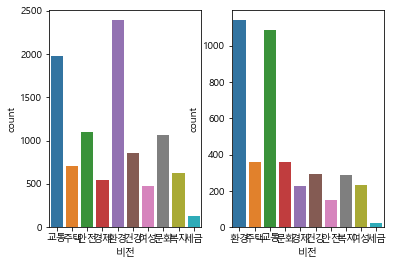

In [109]:
#학습 데이터 비전 비율 vs 테스트 데이터 비전 비율
ig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.countplot(train_df['비전'], ax=axes[0]) #학습 데이터
sns.countplot(output_w2v['비전'], ax=axes[1]) #테스트 데이터